### Load product review csv to pandas data frame and inspect data

In [1]:
import pandas as pd
reviews = pd.read_csv('amazon_baby_products.csv')

In [2]:
reviews.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


#### How does a review with rating 1 look like?

In [3]:
reviews[reviews['rating'] == 1]['review'].iloc[0]

'This book is boring. Nothing to stimulate my granddaughter. It is a waste of money. I would not recommend it'

#### And one with rating 5?

In [4]:
reviews[reviews['rating'] == 5]['review'].iloc[20]

'we just got this book for our one-year-old and she loves it.  It\\\'s so nice that she can\\\'t bite chunks out of it like she can a board book or rip it like a paper one.  She can chew on it, pull on it, and carry it all over the house!  She loves the little flaps that open and is learning simple words like "daddy," "mommy," "puppy," etc.  We love it.'

### Check missing data and drop incomplete rows

In [5]:
print '%d rows' % len(reviews)
reviews.isnull().sum()

183531 rows


name      318
review    829
rating      0
dtype: int64

In [6]:
reviews = reviews.dropna()

In [7]:
print '%d rows' % len(reviews)
reviews.isnull().sum()

182384 rows


name      0
review    0
rating    0
dtype: int64

### Let's explore further

#### What's the distribution of the ratings

In [8]:
print '%d reviews, %d different items' % (len(reviews), len(reviews['name'].unique()))
print 'Ratings:'
pd.Series.value_counts(reviews['rating'], sort = False)

182384 reviews, 32315 different items
Ratings:


1     15100
2     11261
3     16705
4     33053
5    106265
Name: rating, dtype: int64

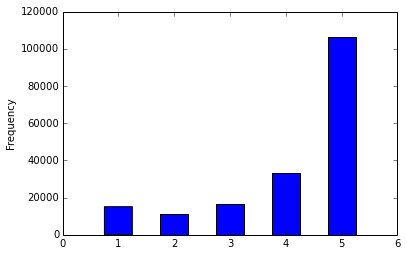

In [9]:
%matplotlib inline
reviews['rating'].plot(kind='hist', range=(1, 6), align = 'left')

People like sharing good experiences :)

#### Find the most bought product

In [10]:
reviews.groupby('name').count().sort_values(['review'], ascending=False).head(n=10)

,review,rating
name,,
Vulli Sophie the Giraffe Teether,779,779
"Simple Wishes Hands-Free Breastpump Bra, Pink, XS-L",560,560
Infant Optics DXR-5 2.4 GHz Digital Video Baby Monitor with Night Vision,558,558
Baby Einstein Take Along Tunes,545,545
"Cloud b Twilight Constellation Night Light, Turtle",517,517
"Fisher-Price Booster Seat, Blue/Green/Gray",487,487
Fisher-Price Rainforest Jumperoo,446,446
"Graco Nautilus 3-in-1 Car Seat, Matrix",418,418
Leachco Snoogle Total Body Pillow,388,388


#### Let's focus on a chewing toy

In [11]:
giraffe_reviews = reviews[reviews['name'] == 'Vulli Sophie the Giraffe Teether']

In [12]:
len(giraffe_reviews)

779

In [13]:
giraffe_reviews['rating'].value_counts(sort = False, normalize = True)

1    0.071887
2    0.047497
3    0.079589
4    0.119384
5    0.681643
Name: rating, dtype: float64

### Build a sentiment classifier

#### Define what's a positive and a negative sentiment
We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment.  Reviews with a rating of 4 or higher will be considered positive, while the ones with rating of 2 or lower will have a negative sentiment.   

In [14]:
#ignore all 3* reviews
products = reviews[reviews['rating'] != 3]

#positive sentiment = 4* or 5* reviews
products.loc[:, 'sentiment'] = 0
products.loc[products.rating >= 4, 'sentiment'] = 1

products.iloc[15:25]

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,name,review,rating,sentiment
17,Nature\'s Lullabies Second Year Sticker Calendar,This was the only calender I could find for th...,5,1
18,Nature\'s Lullabies Second Year Sticker Calendar,I completed a calendar for my son\'s first yea...,4,1
19,Nature\'s Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
20,Nature\'s Lullabies Second Year Sticker Calendar,I had a hard time finding a second year calend...,5,1
21,Nature\'s Lullabies Second Year Sticker Calendar,I only purchased a second-year calendar for my...,2,0
22,Nature\'s Lullabies Second Year Sticker Calendar,I LOVE this calendar for recording events of m...,5,1
24,Nature\'s Lullabies Second Year Sticker Calendar,Wife loves this calender. Comes with a lot of ...,5,1
25,Nature\'s Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
26,Baby\'s First Journal - Green,"Extremely useful! As a new mom, tired and inex...",5,1
28,"Lamaze Peekaboo, I Love You","One of baby\'s first and favorite books, and i...",4,1


In [15]:
pd.set_option('precision', 2)
products.describe()

,rating,sentiment
count,165679.00,165679.00
mean,4.23,0.84
std,1.30,0.37
min,1.00,0.00
25%,4.00,1.00
50%,5.00,1.00
75%,5.00,1.00
max,5.00,1.00


#### Calculate the word count vector for each review

##### First let's do it for all words present in any review then for just some selected ones

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer()

In [17]:
# The resulting array is big and sparse
count_features=countvec.fit_transform(products.review)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [18]:
# We can show the word counts for a small subset of words
interesting_words = ['like', 'amazing', 'love', 'horrible', 'bad', 'meh', 'awful']
cv_some_words = CountVectorizer(vocabulary = interesting_words) 
some_words = pd.DataFrame(cv_some_words.fit_transform(products.review).toarray(), 
                          columns=cv_some_words.get_feature_names())

In [19]:
some_words.head()

,like,amazing,love,horrible,bad,meh,awful
0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0
2,1,0,2,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0


#### Fit a Logistic Regression model

In [20]:
from sklearn.cross_validation import train_test_split

In [21]:
X = count_features
y = products.sentiment

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from sklearn.linear_model import LogisticRegression
# our model - a multiclass regression
logistic = LogisticRegression()

# train on iris training set
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Let's evaluate the model performance

In [24]:
pred = logistic.predict(X_test)

In [25]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
# Area under the ROC curve
metrics.auc(fpr, tpr)

0.85278639391898869

In [26]:
# How are the categories misclassified
metrics.confusion_matrix(y_test, pred, labels = [0, 1])

array([[ 5890,  2135],
       [ 1183, 40496]])

In [27]:
# How much of the predictions are correct
# In the lecture we got 'accuracy': 0.916256305548883
metrics.accuracy_score(y_test, pred, normalize=True)

0.9332448092708836

#### Let's see how our model rates Sophie's reviews

In [34]:
# Instead of the category we can see the predicted probabilities
probs = logistic.predict_proba(X)

products.loc[:,'neg_prob'] = probs[:,0]
products.loc[:,'pos_prob'] = probs[:,1]

In [43]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']
giraffe_reviews.head()

,name,review,rating,sentiment,neg_prob,pos_prob
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,1,1.64e-03,1.00
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,1,3.99e-04,1.00
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,0,4.35e-01,0.56
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5,1,4.00e-02,0.96
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,1,5.22e-01,0.48


In [48]:
giraffe_reviews = giraffe_reviews.sort_values(by = 'pos_prob', ascending = False)

In [49]:
giraffe_reviews.head()

,name,review,rating,sentiment,neg_prob,pos_prob
34892,Vulli Sophie the Giraffe Teether,"Sophie, oh Sophie, your time has come. My gran...",5,1,1.73e-13,1
34434,Vulli Sophie the Giraffe Teether,My Mom-in-Law bought Sophie for my son when he...,5,1,2.51e-09,1
34442,Vulli Sophie the Giraffe Teether,"Yes, it\'s imported. Yes, it\'s expensive. And...",5,1,2.86e-09,1
34515,Vulli Sophie the Giraffe Teether,"As every mom knows, you always want to give yo...",5,1,6.35e-09,1
34341,Vulli Sophie the Giraffe Teether,I\'ll be honest...I bought this toy because al...,4,1,1.06e-07,1


In [52]:
# Most positive review for Sophie
giraffe_reviews.iloc[0]['review']

"Sophie, oh Sophie, your time has come. My granddaughter, Violet is 5 months old and starting to teeth. What joy little Sophie brings to Violet. Sophie is made of a very pliable rubber that is sturdy but not tough. It is quite easy for Violet to twist Sophie into unheard of positions to get Sophie into her mouth. The little nose and hooves fit perfectly into small mouths, and the drooling has purpose. The paint on Sophie is food quality.Sophie was born in 1961 in France. The maker had wondered why there was nothing available for babies and made Sophie from the finest rubber, phthalate-free on St Sophie\\'s Day, thus the name was born. Since that time millions of Sophie\\'s populate the world. She is soft and for babies little hands easy to grasp. Violet especially loves the bumpy head and horns of Sophie. Sophie has a long neck that easy to grasp and twist. She has lovely, sizable spots that attract Violet\\'s attention. Sophie has happy little squeaks that bring squeals of delight fro

In [57]:
giraffe_reviews.tail()

,name,review,rating,sentiment,neg_prob,pos_prob
34709,Vulli Sophie the Giraffe Teether,i looked at this teether forever before i fina...,4,1,1,2.14e-04
34994,Vulli Sophie the Giraffe Teether,When I received this the paint was peeling off...,1,0,1,2.00e-04
34824,Vulli Sophie the Giraffe Teether,I got one of these as a showe gift that my bab...,1,0,1,1.02e-04
34732,Vulli Sophie the Giraffe Teether,Received the product and smells like cheap rub...,1,0,1,6.12e-05
34687,Vulli Sophie the Giraffe Teether,I wanted to love this product and was excited ...,1,0,1,1.47e-08


In [54]:
# Most negative review for Sophie
giraffe_reviews.iloc[-1]['review']

'I wanted to love this product and was excited to buy it when I became pregnant but am now hesitant to let my baby use it after reading about the recall in Europe. Apparently, as I understand it, their toxin standards of measurement are lower than ours so they have not been recalled here (apparently we are OK with low levels of nitrates in the toys our children put in their mouths, but Europeans are not...hmmm)...Be that as it may, toxins registering even CLOSE to a dangerous level made me nervous about using. After digging around online I did discover that the company claims to have changed the product after a certain date and lists manufacturing codes so you can check yours (those listed were made after a certain date and are said to be safer). Sadly mine was not made after the &#34;improved&#34; date but I could not return it because there was no formal recall in our country. I considered returning it and hunting for one with an approved manufacturing date but man that was just too 

In [58]:
# Although rating was 4* our classifier picked up the negative tone of this review
giraffe_reviews.iloc[-5]['review']

'i looked at this teether forever before i finally broke down and paid $19. for it, it says that the paint does not come off and it does, my son is only 3 months old and is teething but has no teeth through yet but is still able to suck the paint off of it and i wiped it down with a wipe and the paint on her eyes also comes off, i cannot understand why ppl have said that the spots are actually a part of her rubber body because they are painted on and they do come off and im very unhappy about this because i read all the good reviews about it and finallt decided to order it and im very disappointed.'